In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
data=pd.read_csv('../data/crsp_stock_data.csv')
data.head(5)

/Users/jacobbarcelona/.pyenv/versions/3.9.16/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3526: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,PERMNO,date,TICKER,COMNAM,PRC,RET,SHROUT,CFACPR,CFACSHR
0,10001,1990-01-02,GFGC,GREAT FALLS GAS CO,10.1250,0.000000,1022.0,3.0,3.0
1,10001,1990-01-03,GFGC,GREAT FALLS GAS CO,10.0000,-0.012346,1022.0,3.0,3.0
2,10001,1990-01-04,GFGC,GREAT FALLS GAS CO,10.0000,0.000000,1022.0,3.0,3.0
3,10001,1990-01-05,GFGC,GREAT FALLS GAS CO,-10.0625,0.006250,1022.0,3.0,3.0
4,10001,1990-01-08,GFGC,GREAT FALLS GAS CO,10.1250,0.006211,1022.0,3.0,3.0


In [3]:
goog=data[data['date']==datetime(2014,4,3)]
goog[goog['TICKER']=='GOOG']


,PERMNO,date,TICKER,COMNAM,PRC,RET,SHROUT,CFACPR,CFACSHR


In [4]:
factors=pd.read_csv('../data/F-F_Research_Data_Factors.CSV')
factors

,date,Mkt-RF,SMB,HML,RF
0,192607,2.96,-2.56,-2.43,0.22
1,192608,2.64,-1.17,3.82,0.25
2,192609,0.36,-1.40,0.13,0.23
3,192610,-3.24,-0.09,0.70,0.32
4,192611,2.53,-0.10,-0.51,0.31
...,...,...,...,...,...
1160,202303,2.51,-5.51,-8.85,0.36
1161,202304,0.61,-3.35,-0.04,0.35
1162,202305,0.35,1.61,-7.72,0.36
1163,202306,6.46,1.54,-0.26,0.40


In [5]:
# Assuming 'data' is your original stock data and 'factors' is your factor data
# Convert 'date' in 'data' DataFrame to datetime
data['date'] = pd.to_datetime(data['date'])
data['MonthYear'] = data['date'].dt.to_period('M')

# Convert non-numeric 'RET' to NaN and then drop those rows
data['RET'] = pd.to_numeric(data['RET'], errors='coerce')
data = data.dropna(subset=['RET'])

# Convert 'date' in 'factors' DataFrame from 'YYYYMM' format to datetime
factors['date'] = pd.to_datetime(factors['date'], format='%Y%m')
factors['MonthYear'] = factors['date'].dt.to_period('M')

# Forward fill the factors for each month
factors = factors.set_index('date').resample('D').ffill().reset_index()
factors['MonthYear'] = factors['date'].dt.to_period('M')

# Calculate Market Cap
data['MktCap'] = data.apply(lambda x: abs(x['PRC']) * x['SHROUT'] if x['PRC'] != 0 else pd.NA, axis=1)
data['MktCap'] = pd.to_numeric(data['MktCap'], errors='coerce')  # Convert Market Cap to numeric, handling errors

# Drop rows where Market Cap is NA
data = data.dropna(subset=['MktCap'])

# Selecting the last day of each month and the top 500 companies based on Market Cap
last_day_each_month = data.groupby('MonthYear')['date'].transform('max')
data_last_day = data[data['date'] == last_day_each_month]

# Select the Top 500 firms based on Market Cap on the last day of each month
top500_last_day = data_last_day.groupby('MonthYear').apply(lambda x: x.nlargest(500, 'MktCap')).reset_index(drop=True)

# Preparing for Next Month's Data
top500_last_day['NextMonth'] = top500_last_day['MonthYear'].apply(lambda x: x + 1)
top500_map = top500_last_day[['NextMonth', 'TICKER']].drop_duplicates()

# Merging with the original data to create the stock universe for the next month
data['NextMonth'] = data['MonthYear']
resulting_df = pd.merge(data, top500_map, on=['NextMonth', 'TICKER'])

# Merge the factors with the filtered stock data
resulting_df = pd.merge(resulting_df, factors, on='date', how='left')

# Select Relevant Columns for the Resulting DataFrame
resulting_df = resulting_df[['date', 'TICKER', 'RET', 'MktCap', 'Mkt-RF', 'SMB', 'HML', 'RF']]

# Sort the DataFrame by date for easier analysis and visualization
resulting_df = resulting_df.sort_values(by='date')

# Output the resulting DataFrame
print(resulting_df.head())


              date TICKER       RET       MktCap  Mkt-RF   SMB   HML    RF
0       1990-02-01   SUNW  0.012903  1674149.875    1.11  0.99  0.64  0.57
85025   1990-02-01    CPC -0.019011  5012359.500    1.11  0.99  0.64  0.57
1498951 1990-02-01    ABS  0.016706  3568442.250    1.11  0.99  0.64  0.57
1496739 1990-02-01    WFC -0.007590  3369558.250    1.11  0.99  0.64  0.57
1493911 1990-02-01   LIZC  0.011236  1982565.000    1.11  0.99  0.64  0.57


In [6]:
resulting_df

,date,TICKER,RET,MktCap,Mkt-RF,SMB,HML,RF
0,1990-02-01,SUNW,0.012903,1.674150e+06,1.11,0.99,0.64,0.57
85025,1990-02-01,CPC,-0.019011,5.012360e+06,1.11,0.99,0.64,0.57
1498951,1990-02-01,ABS,0.016706,3.568442e+06,1.11,0.99,0.64,0.57
1496739,1990-02-01,WFC,-0.007590,3.369558e+06,1.11,0.99,0.64,0.57
1493911,1990-02-01,LIZC,0.011236,1.982565e+06,1.11,0.99,0.64,0.57
...,...,...,...,...,...,...,...,...
351684,2015-12-31,KHC,-0.013424,8.832911e+07,-2.17,-2.84,-2.61,0.01
358016,2015-12-31,PYPL,-0.007675,4.430880e+07,-2.17,-2.84,-2.61,0.01
2777612,2015-12-31,PLD,-0.007401,2.250343e+07,-2.17,-2.84,-2.61,0.01
2767684,2015-12-31,YUM,-0.010297,3.150223e+07,-2.17,-2.84,-2.61,0.01


In [7]:
resulting_df['RET']

date      0
TICKER    0
RET       0
MktCap    0
Mkt-RF    0
SMB       0
HML       0
RF        0
dtype: int64

In [8]:
resulting_df.to_csv('../data/stock_data_with_factors.csv')

In [60]:
rates=pd.read_csv('../data/FEDFUNDS.csv')

In [5]:
rates

,DATE,FEDFUNDS
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83
...,...,...
828,2023-07-01,5.12
829,2023-08-01,5.33
830,2023-09-01,5.33
831,2023-10-01,5.33


In [9]:
import pandas as pd

# Convert financial columns to float
resulting_df['RET'] = pd.to_numeric(resulting_df['RET'], errors='coerce')
factors['Mkt-RF'] = pd.to_numeric(factors['Mkt-RF'], errors='coerce')
factors['SMB'] = pd.to_numeric(factors['SMB'], errors='coerce')
factors['HML'] = pd.to_numeric(factors['HML'], errors='coerce')
factors['RF'] = pd.to_numeric(factors['RF'], errors='coerce')

# Convert date formats in both DataFrames to ensure they match
resulting_df['date'] = pd.to_datetime(resulting_df['date'])
factors['date'] = pd.to_datetime(factors['date']).dt.to_period('M').dt.to_timestamp()

# Merge the factors DataFrame with the resulting_df DataFrame
merged_df = pd.merge(resulting_df, factors, on='date', how='left')
merged_df.fillna(method='ffill', inplace=True)  # Forward fill the monthly data

# Calculating Adjusted Returns
merged_df['Adj_RET_Mkt'] = merged_df['RET'] - merged_df['Mkt-RF']
merged_df['Adj_RET_Mkt_SMB'] = merged_df['Adj_RET_Mkt'] - merged_df['SMB']
merged_df['Adj_RET_Mkt_SMB_HML'] = merged_df['Adj_RET_Mkt_SMB'] - merged_df['HML']

# Convert interest rates to float and prepare for merge
rates['DATE'] = pd.to_datetime(rates['DATE']).dt.to_period('M').dt.to_timestamp()
rates['FEDFUNDS'] = pd.to_numeric(rates['FEDFUNDS'], errors='coerce')

# Merge the rates DataFrame with the merged_df DataFrame
merged_with_rates_df = pd.merge(merged_df, rates, left_on='date', right_on='DATE', how='left')
merged_with_rates_df.fillna(method='ffill', inplace=True)  # Forward fill the monthly data

# Check the results
print(merged_with_rates_df.head())


        date TICKER       RET       MktCap  Mkt-RF  SMB  HML  RF  Adj_RET_Mkt  \
0 1990-02-01   SUNW  0.012903  1674149.875     NaN  NaN  NaN NaN          NaN   
1 1990-02-01    HON  0.018462  3577944.500     NaN  NaN  NaN NaN          NaN   
2 1990-02-01    DNB -0.005634  8249654.125     NaN  NaN  NaN NaN          NaN   
3 1990-02-01     JP  0.016447  1452338.625     NaN  NaN  NaN NaN          NaN   
4 1990-02-01    MTC -0.004723  7037574.750     NaN  NaN  NaN NaN          NaN   

   Adj_RET_Mkt_SMB  Adj_RET_Mkt_SMB_HML       DATE  FEDFUNDS  
0              NaN                  NaN 1990-02-01      8.24  
1              NaN                  NaN 1990-02-01      8.24  
2              NaN                  NaN 1990-02-01      8.24  
3              NaN                  NaN 1990-02-01      8.24  
4              NaN                  NaN 1990-02-01      8.24  


In [10]:
merged_with_rates_df

,date,TICKER,RET,MktCap,Mkt-RF,SMB,HML,RF,Adj_RET_Mkt,Adj_RET_Mkt_SMB,Adj_RET_Mkt_SMB_HML,DATE,FEDFUNDS
0,1990-02-01,SUNW,0.012903,1.674150e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990-02-01,8.24
1,1990-02-01,HON,0.018462,3.577944e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990-02-01,8.24
2,1990-02-01,DNB,-0.005634,8.249654e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990-02-01,8.24
3,1990-02-01,JP,0.016447,1.452339e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990-02-01,8.24
4,1990-02-01,MTC,-0.004723,7.037575e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990-02-01,8.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3275075,2015-12-31,EIX,-0.018076,1.929127e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-12-01,0.24
3275076,2015-12-31,MAR,-0.014407,1.699343e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-12-01,0.24
3275077,2015-12-31,HSY,-0.014680,1.394165e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-12-01,0.24
3275078,2015-12-31,KR,-0.011345,4.077266e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-12-01,0.24


In [11]:
#export
merged_with_rates_df.to_csv('../data/corrected_crsp_ff_adjusted.csv')

In [37]:
original=pd.read_csv('../data/crsp_ff_adjusted.csv')
original

,Unnamed: 0,date,TICKER,RET,Adj_RET_Mkt,Adj_RET_Mkt_SMB,Adj_RET_Mkt_SMB_HML
0,0,1990-02-01,SUNW,0.012903,7.292903,8.532903,7.682903
1,243076,1990-02-01,MYG,0.014085,7.294085,8.534085,7.684085
2,1688937,1990-02-01,INTC,-0.012658,7.267342,8.507342,7.657342
3,1680427,1990-02-01,CB,0.005634,7.285634,8.525634,7.675634
4,1675688,1990-02-01,BUD,-0.026490,7.253510,8.493510,7.643510
...,...,...,...,...,...,...,...
3266862,228605,2015-12-31,KMI,0.026135,-0.533865,-4.133865,-3.713865
3266863,66360,2015-12-31,ADM,-0.005423,-0.565423,-4.165423,-3.745423
3266864,374087,2015-12-31,HPE,-0.005236,-0.565236,-4.165236,-3.745236
3266865,954405,2015-12-31,DIS,-0.011849,-0.571849,-4.171849,-3.751849


In [38]:
original.isna().sum()

Unnamed: 0             0
date                   0
TICKER                 0
RET                    0
Adj_RET_Mkt            0
Adj_RET_Mkt_SMB        0
Adj_RET_Mkt_SMB_HML    0
dtype: int64

In [39]:
# Ensure 'date' is in the correct format
original['date'] = pd.to_datetime(original['date'])

# Extract year and month from 'date' for grouping
original['YearMonth'] = original['date'].dt.to_period('M')

# Group by YearMonth and count unique tickers for each month
ticker_counts_per_month = original.groupby('YearMonth')['TICKER'].nunique()

# Display the counts
print(ticker_counts_per_month)

YearMonth
1990-02    496
1990-03    499
1990-04    500
1990-05    500
1990-06    499
          ... 
2015-08    497
2015-09    499
2015-10    499
2015-11    500
2015-12    499
Freq: M, Name: TICKER, Length: 311, dtype: int64


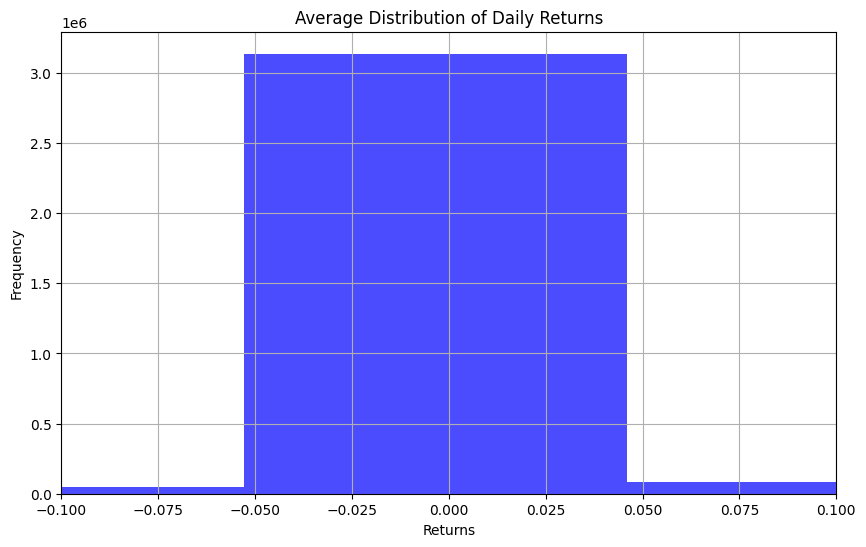

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming merged_with_rates_df is your DataFrame
df = pd.read_csv('../data/stock_data_with_factors.csv')

# Ensure the 'RET' column is in a suitable numeric format
df['RET'] = pd.to_numeric(df['RET'], errors='coerce')

# Plot the distribution of returns for the entire dataset
plt.figure(figsize=(10, 6))
plt.hist(df['RET'].dropna(), bins=50, alpha=0.7, color='blue')  # Adjust the number of bins as needed
plt.title('Average Distribution of Daily Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.grid(True)

# Set x-axis limits to zoom in on the center of the distribution
plt.xlim(-0.1, 0.1)  # Adjust these limits as needed to zoom in appropriately

plt.show()


# S&P Components Set

In [61]:
sp_data=pd.read_csv('../data/S&P 500 Historical Components & Changes(08-01-2023).csv')

In [62]:


# Assuming 'data' is your original stock data and 'sp_data' is the new DataFrame with S&P tickers

# Step 1: Preprocess the Additional DataFrame
sp_data['date'] = pd.to_datetime(sp_data['date'])
sp_data['MonthYear'] = sp_data['date'].dt.to_period('M')
sp_data['tickers'] = sp_data['tickers'].str.split(',')

# Exploding the tickers list into separate rows
sp_data = sp_data.explode('tickers')

# Step 2: Create Monthly Universe
sp_monthly_universe = sp_data.groupby('MonthYear')['tickers'].unique().reset_index()

# Step 3: Shift Forward to Avoid Lookahead Bias
sp_monthly_universe['NextMonth'] = sp_monthly_universe['MonthYear'].apply(lambda x: x + 1)

# Create a DataFrame from the Monthly Universe
sp_universe_expanded = sp_monthly_universe.explode('tickers')

# Step 4: Merge with the Original Data
data['MonthYear'] = pd.to_datetime(data['date']).dt.to_period('M')
data['NextMonth'] = data['MonthYear']
sp_universe = pd.merge(data, sp_universe_expanded[['NextMonth', 'tickers']], left_on=['NextMonth', 'TICKER'], right_on=['NextMonth', 'tickers'])

# Select Relevant Columns for the Resulting DataFrame
sp_universe = sp_universe[['date', 'TICKER', 'RET']]

# Sort the DataFrame by date for easier analysis and visualization
sp_universe = sp_universe.sort_values(by='date')

# Output the resulting DataFrame
print(sp_universe.head())


               date TICKER       RET
282359   1996-02-01     KR  0.032374
933515   1996-02-01    AVY  0.007026
1082565  1996-02-01   MCIC  0.017467
1242596  1996-02-01     DJ  0.003195
651903   1996-02-01    CAR -0.043478


In [63]:
sp_universe

,date,TICKER,RET
282359,1996-02-01,KR,0.032374
933515,1996-02-01,AVY,0.007026
1082565,1996-02-01,MCIC,0.017467
1242596,1996-02-01,DJ,0.003195
651903,1996-02-01,CAR,-0.043478
...,...,...,...
1817111,2015-12-31,EMN,-0.004277
1204938,2015-12-31,CAG,-0.010096
2118863,2015-12-31,ILMN,0.004579
523324,2015-12-31,TXT,-0.010365


In [64]:
sp_universe.isna().sum()

date        0
TICKER      0
RET       379
dtype: int64

In [65]:
sp_universe=sp_universe.dropna(subset=['RET'])

In [66]:
# Ensure 'date' is in the correct format
sp_universe['date'] = pd.to_datetime(sp_universe['date'])

# Extract year and month from 'date' for grouping
sp_universe['YearMonth'] = sp_universe['date'].dt.to_period('M')

# Group by YearMonth and count unique tickers for each month
ticker_counts_per_month = sp_universe.groupby('YearMonth')['TICKER'].nunique()

# Display the counts
print(ticker_counts_per_month)

/var/folders/bm/bm_nkxfx3w1303dr6gyz9cg00000gn/T/ipykernel_69937/1698426033.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp_universe['date'] = pd.to_datetime(sp_universe['date'])
/var/folders/bm/bm_nkxfx3w1303dr6gyz9cg00000gn/T/ipykernel_69937/1698426033.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp_universe['YearMonth'] = sp_universe['date'].dt.to_period('M')


YearMonth
1996-02    404
1996-03    402
1996-04    404
1996-05    404
1996-06    404
          ... 
2015-08    485
2015-09    483
2015-10    486
2015-11    486
2015-12    489
Freq: M, Name: TICKER, Length: 239, dtype: int64


In [67]:
factors

,date,Mkt-RF,SMB,HML,RF
0,192607,2.96,-2.56,-2.43,0.22
1,192608,2.64,-1.17,3.82,0.25
2,192609,0.36,-1.40,0.13,0.23
3,192610,-3.24,-0.09,0.70,0.32
4,192611,2.53,-0.10,-0.51,0.31
...,...,...,...,...,...
1160,202303,2.51,-5.51,-8.85,0.36
1161,202304,0.61,-3.35,-0.04,0.35
1162,202305,0.35,1.61,-7.72,0.36
1163,202306,6.46,1.54,-0.26,0.40


In [68]:


# Assuming sp_universe, factors, and rates are your DataFrames

# Convert date in sp_universe to Period (YearMonth)
sp_universe['YearMonth'] = sp_universe['date'].dt.to_period('M')

# Convert string dates in factors to Period (YearMonth)
factors['YearMonth'] = factors['date'].astype(str).apply(lambda x: pd.Period(year=int(x[:4]), month=int(x[4:]), freq='M'))

# Ensure DATE in rates is in datetime format, then convert to Period (YearMonth)
rates['DATE'] = pd.to_datetime(rates['DATE'], format='%Y-%m-%d')  # Adjust format string as necessary
rates['YearMonth'] = rates['DATE'].dt.to_period('M')

# Merge the factors DataFrame with sp_universe
merged_universe = pd.merge(sp_universe, factors[['YearMonth', 'Mkt-RF', 'SMB', 'HML', 'RF']], on='YearMonth', how='left')

# Merge the rates DataFrame
merged_universe = pd.merge(merged_universe, rates[['YearMonth', 'FEDFUNDS']], on='YearMonth', how='left')

# Forward fill the monthly data
monthly_columns = ['Mkt-RF', 'SMB', 'HML', 'RF', 'FEDFUNDS']
merged_universe[monthly_columns] = merged_universe[monthly_columns].fillna(method='ffill')

# Drop the YearMonth column if no longer needed
merged_universe.drop(columns=['YearMonth'], inplace=True)

# Check the results after merging
print(merged_universe.head())



/var/folders/bm/bm_nkxfx3w1303dr6gyz9cg00000gn/T/ipykernel_69937/813777.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp_universe['YearMonth'] = sp_universe['date'].dt.to_period('M')


        date TICKER       RET  Mkt-RF   SMB   HML    RF  FEDFUNDS
0 1996-02-01     KR  0.032374    1.33  1.79 -1.08  0.39      5.22
1 1996-02-01    AVY  0.007026    1.33  1.79 -1.08  0.39      5.22
2 1996-02-01   MCIC  0.017467    1.33  1.79 -1.08  0.39      5.22
3 1996-02-01     DJ  0.003195    1.33  1.79 -1.08  0.39      5.22
4 1996-02-01    CAR -0.043478    1.33  1.79 -1.08  0.39      5.22


In [69]:
merged_universe

,date,TICKER,RET,Mkt-RF,SMB,HML,RF,FEDFUNDS
0,1996-02-01,KR,0.032374,1.33,1.79,-1.08,0.39,5.22
1,1996-02-01,AVY,0.007026,1.33,1.79,-1.08,0.39,5.22
2,1996-02-01,MCIC,0.017467,1.33,1.79,-1.08,0.39,5.22
3,1996-02-01,DJ,0.003195,1.33,1.79,-1.08,0.39,5.22
4,1996-02-01,CAR,-0.043478,1.33,1.79,-1.08,0.39,5.22
...,...,...,...,...,...,...,...,...
2260944,2015-12-31,EMN,-0.004277,-2.17,-2.84,-2.61,0.01,0.24
2260945,2015-12-31,CAG,-0.010096,-2.17,-2.84,-2.61,0.01,0.24
2260946,2015-12-31,ILMN,0.004579,-2.17,-2.84,-2.61,0.01,0.24
2260947,2015-12-31,TXT,-0.010365,-2.17,-2.84,-2.61,0.01,0.24


In [70]:
merged_universe.to_csv('../data/spy_universe.csv')

## Price to Returns data YFinance